# SustainCluster: Evaluation and Demonstration

Welcome to the SustainCluster evaluation notebook!

This notebook demonstrates how to:
1. Configure and run the SustainCluster simulation environment.
2. Evaluate the performance of pre-trained Reinforcement Learning (RL) agents.
3. Compare RL agents against various Rule-Based Controllers (RBCs).
4. Visualize key performance metrics and environmental dynamics.

**Project Repository:** [https://github.com/HewlettPackard/sustain-cluster](https://github.com/HewlettPackard/sustain-cluster)

## 1. Setup and Imports

First, ensure you have cloned the repository and set up the Conda environment as described in the main `README.md` or documentation. This notebook assumes it is being run from the root of the SustainCluster project directory.

In [1]:
import sys
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml # For loading algo_config if needed for agent params
import datetime
import logging
import random
import copy
from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter

# Add the project root directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '.')) # Assumes notebook is in project root
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to Python path: {project_root}")

Added project root to Python path: /lustre/guillant/new_green-dcc


In [2]:
# Local Imports
from rl_components.agent_net import ActorNet, AttentionActorNet
from envs.task_scheduling_env import TaskSchedulingEnv
from simulation.cluster_manager import DatacenterClusterManager
from utils.config_loader import load_yaml
from rewards.predefined.composite_reward import CompositeReward
from utils.config_logger import setup_logger # Can be simplified for notebook
from utils.checkpoint_manager import load_checkpoint_data

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("Setup Complete. Libraries imported.")

Setup Complete. Libraries imported.


## 2. Evaluation Configuration

Modify the parameters in the next code cell to define your evaluation run.

**Key Parameters:**
*   `CONTROLLER_TYPE`: Choose between `"RL"` (for a Reinforcement Learning agent) or `"RBC"` (for a Rule-Based Controller).
*   `RL_AGENT_CHECKPOINT_PATH`: If `CONTROLLER_TYPE` is `"RL"`, specify the path to the trained agent's checkpoint (`.pth` file). Four example checkpoints are provided for different SAC agent configurations.
*   `RBC_STRATEGY`: If `CONTROLLER_TYPE` is `"RBC"`, choose the RBC strategy (e.g., `"local_only"`, `"lowest_carbon"`, `"lowest_price"`, `"most_available"`, `"round_robin"`).
*   `EVALUATION_DURATION_DAYS`: How many simulated days to run the evaluation for.
*   `EVALUATION_SEED`: The random seed for reproducibility.

In [26]:
# --- USER CONFIGURABLE PARAMETERS ---

CONTROLLER_TYPE = "RL"  # Options: "RL" or "RBC"

# --- For RL Agent Evaluation ---
# Example checkpoint paths (uncomment the one you want to use):
RL_AGENT_CHECKPOINT_PATH = "checkpoints/train_multiaction_defer_20250527_210534/best_eval_checkpoint.pth" # Multi-Action SAC + Deferral
# RL_AGENT_CHECKPOINT_PATH = "checkpoints/train_multiaction_nodefer_20250527_212105/best_eval_checkpoint.pth" # Multi-Action SAC, No Deferral
# RL_AGENT_CHECKPOINT_PATH = 'checkpoints/train_single_action_enable_defer_20250527_222926/best_eval_checkpoint.pth' # Single-Action SAC + Deferral
# RL_AGENT_CHECKPOINT_PATH = 'checkpoints/train_single_action_disable_defer_20250527_223002/best_eval_checkpoint.pth' # Single-Action SAC, No Deferral

# --- For RBC Evaluation ---
RBC_STRATEGY = "local_only"  # Options: "local_only", "lowest_carbon", "lowest_price", "most_available", "round_robin", "least_pending", "lowest_utilization"

# --- General Evaluation Settings ---
EVALUATION_DURATION_DAYS = 7 # Number of days to simulate
EVALUATION_SEED = 123        # Random seed for reproducibility

# --- Paths to Configuration Files (relative to project root) ---
CONFIG_DIR = "configs/env"
BASE_SIM_CONFIG_PATH = os.path.join(CONFIG_DIR, "sim_config.yaml")
BASE_DC_CONFIG_PATH = os.path.join(CONFIG_DIR, "datacenters.yaml")
BASE_REWARD_CONFIG_PATH = os.path.join(CONFIG_DIR, "reward_config.yaml")
# BASE_ALGO_CONFIG_PATH = os.path.join(CONFIG_DIR, "algorithm_config.yaml") # Needed to infer agent config if not in checkpoint

# --- Logger Setup (Simplified for Notebook) ---
# We'll print info directly or use basic logging for clarity in the notebook
logger = logging.getLogger("SustainCluster_Eval_Notebook")
if not logger.handlers: # Avoid duplicate handlers if cell is re-run
    logger.setLevel(logging.INFO)
    console_handler_nb = logging.StreamHandler(sys.stdout) # Log to notebook output
    console_handler_nb.setLevel(logging.INFO)
    console_handler_nb.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(console_handler_nb)

logger.info("Evaluation Parameters Set:")
logger.info(f"  Controller Type: {CONTROLLER_TYPE}")
if CONTROLLER_TYPE == "RL":
    logger.info(f"  RL Agent Checkpoint: {RL_AGENT_CHECKPOINT_PATH}")
else:
    logger.info(f"  RBC Strategy: {RBC_STRATEGY}")
logger.info(f"  Evaluation Duration: {EVALUATION_DURATION_DAYS} days")
logger.info(f"  Evaluation Seed: {EVALUATION_SEED}")

[INFO] Evaluation Parameters Set:
[INFO]   Controller Type: RL
[INFO]   RL Agent Checkpoint: checkpoints/train_multiaction_defer_20250527_210534/best_eval_checkpoint.pth
[INFO]   Evaluation Duration: 7 days
[INFO]   Evaluation Seed: 123


## 3. Helper Functions

This cell contains the `make_eval_env` function, which sets up the SustainCluster environment based on the chosen configuration. It's adapted from the evaluation script.

In [27]:
def make_eval_env(strategy_to_eval_param, base_sim_cfg_dict_param, base_dc_cfg_dict_param, base_reward_cfg_dict_param,
                  eval_duration_days_param, seed_param,
                  env_disable_defer_flag_param: bool,
                  env_single_action_mode_flag_param: bool,
                  eval_mode=True, custom_logger=None):
    """
    Creates the evaluation environment.
    """
    sim_cfg_dict_run = copy.deepcopy(base_sim_cfg_dict_param)
    dc_cfg_dict_run = copy.deepcopy(base_dc_cfg_dict_param)
    reward_cfg_dict_run = copy.deepcopy(base_reward_cfg_dict_param)

    sim_cfg_dict_run["simulation"]["strategy"] = strategy_to_eval_param
    sim_cfg_dict_run["simulation"]["duration_days"] = eval_duration_days_param
    sim_cfg_dict_run["simulation"]["disable_defer_action"] = env_disable_defer_flag_param
    sim_cfg_dict_run["simulation"]["single_action_mode"] = env_single_action_mode_flag_param
    sim_cfg_dict_run["simulation"]["use_tensorboard"] = False # No TensorBoard during eval
    sim_cfg_dict_run["simulation"]["shuffle_datacenters"] = False if eval_mode else True


    effective_logger = custom_logger if custom_logger else logging.getLogger("DummyLogger")
    if custom_logger:
        effective_logger.info(f"Env for '{strategy_to_eval_param}' will run with: "
                             f"disable_defer_action={env_disable_defer_flag_param}, "
                             f"single_action_mode={env_single_action_mode_flag_param}")

    sim_cfg_for_env = sim_cfg_dict_run["simulation"]

    start = pd.Timestamp(datetime.datetime(sim_cfg_for_env["year"], sim_cfg_for_env["month"], sim_cfg_for_env["init_day"],
                                           sim_cfg_for_env["init_hour"], 0, tzinfo=datetime.timezone.utc))
    end = start + datetime.timedelta(days=sim_cfg_for_env["duration_days"])

    cluster = DatacenterClusterManager(
        config_list=dc_cfg_dict_run["datacenters"],
        simulation_year=sim_cfg_for_env["year"],
        init_day=int(sim_cfg_for_env["month"] * 30.5 + sim_cfg_for_env["init_day"]),
        init_hour=sim_cfg_for_env["init_hour"],
        strategy=sim_cfg_for_env["strategy"],
        tasks_file_path=sim_cfg_for_env["workload_path"],
        shuffle_datacenter_order=not eval_mode,
        cloud_provider=sim_cfg_for_env["cloud_provider"],
        logger=None
    )
    reward_fn = CompositeReward(
        components=reward_cfg_dict_run["reward"]["components"],
        normalize=False # No reward normalization during eval
    )
    env = TaskSchedulingEnv(
        cluster_manager=cluster, start_time=start, end_time=end,
        reward_fn=reward_fn, writer=None,
        sim_config=sim_cfg_for_env,
        initial_seed_for_resets=seed_param # Pass seed for env's internal resets
    )
    return env

logger.info("Helper function make_eval_env defined.")


[INFO] Helper function make_eval_env defined.


## 4. Load Configuration and Agent (if applicable)

This cell loads the base configuration files and, if evaluating an RL agent, loads the pre-trained model checkpoint.


In [28]:
# Load base configurations
base_sim_cfg = load_yaml(BASE_SIM_CONFIG_PATH)
base_dc_cfg = load_yaml(BASE_DC_CONFIG_PATH)
base_reward_cfg = load_yaml(BASE_REWARD_CONFIG_PATH)
# base_algo_cfg = load_yaml(BASE_ALGO_CONFIG_PATH)["algorithm"] # Load if needed for agent params

actor_model = None
agent_name_to_log = ""

# --- Determine Environment Creation Flags and Load RL Agent if needed ---
# These flags determine how the TaskSchedulingEnv is initialized.
# For an RL agent, these should match how the agent was TRAINED.
# For RBCs, we usually set them to reflect typical RBC behavior (e.g., no defer, multi-action implicit).

env_setup_single_action_mode = base_sim_cfg["simulation"].get("single_action_mode", False)
env_setup_disable_defer = base_sim_cfg["simulation"].get("disable_defer_action", False)

if CONTROLLER_TYPE == "RL":
    agent_name_to_log = f"RL Agent ({os.path.basename(RL_AGENT_CHECKPOINT_PATH)})"
    strategy_for_env = "manual_rl"
    
    if not os.path.exists(RL_AGENT_CHECKPOINT_PATH):
        logger.error(f"RL Checkpoint not found: {RL_AGENT_CHECKPOINT_PATH}. Please specify a valid path.")
        # Stop execution or raise error
        raise FileNotFoundError(f"RL Checkpoint not found: {RL_AGENT_CHECKPOINT_PATH}")
    else:
        logger.info(f"Loading RL agent from: {RL_AGENT_CHECKPOINT_PATH}")
        checkpoint_data, _ = load_checkpoint_data(path=RL_AGENT_CHECKPOINT_PATH, device="cpu")
        if checkpoint_data is None:
            raise ValueError("Failed to load checkpoint data.")
        
        extra_info = checkpoint_data.get("extra_info", {})
        # These are CRITICAL - they define how the loaded agent was trained
        # and thus how the environment MUST be configured for this agent.
        loaded_ckpt_single_action_mode = extra_info.get("single_action_mode", False) # Default to False if not in ckpt
        loaded_ckpt_disable_defer = extra_info.get("disable_defer_action", False)  # Default to False

        ckpt_obs_dim = extra_info.get("obs_dim")
        ckpt_act_dim = extra_info.get("act_dim")
        ckpt_hidden_dim = extra_info.get("hidden_dim", 256) # Default if not in ckpt
        ckpt_use_attention = extra_info.get("use_attention", False)
        ckpt_use_layer_norm = extra_info.get("use_layer_norm", False)


        if ckpt_obs_dim is None or ckpt_act_dim is None:
            logger.warning(f"obs_dim or act_dim missing from checkpoint extra_info for {RL_AGENT_CHECKPOINT_PATH}. "
                           "Attempting to infer from environment based on mode, but this might be risky.")
            # Fallback: create a temp env based on flags to get dims (less robust)
            # This is where storing these in the checkpoint is superior.
            temp_env_sim_cfg = copy.deepcopy(base_sim_cfg)
            temp_env_sim_cfg["simulation"]["single_action_mode"] = loaded_ckpt_single_action_mode
            temp_env_sim_cfg["simulation"]["disable_defer_action"] = loaded_ckpt_disable_defer
            temp_env = make_eval_env("manual_rl", temp_env_sim_cfg, base_dc_cfg, base_reward_cfg, 1, 0,
                                     env_disable_defer_flag_param=loaded_ckpt_disable_defer,
                                     env_single_action_mode_flag_param=loaded_ckpt_single_action_mode,
                                     custom_logger=None) # No logger for temp env
            ckpt_obs_dim = temp_env.observation_space.shape[0]
            ckpt_act_dim = temp_env.agent_output_act_dim
            del temp_env
            logger.info(f"Inferred obs_dim: {ckpt_obs_dim}, act_dim: {ckpt_act_dim} for loaded agent.")


        # IMPORTANT: The environment for an RL agent MUST be created with the SAME
        # single_action_mode and disable_defer_action settings the agent was trained with.
        env_setup_single_action_mode = loaded_ckpt_single_action_mode
        env_setup_disable_defer = loaded_ckpt_disable_defer
        logger.info(f"  RL Agent was trained with single_action_mode={loaded_ckpt_single_action_mode}, "
                    f"disable_defer_action={loaded_ckpt_disable_defer}. Environment will be configured accordingly.")

        if ckpt_use_attention:
            attn_cfg_eval = { 
                "embed_dim": extra_info.get("attn_embed_dim", 128),
                "num_heads": extra_info.get("attn_num_heads", 4),
                "num_attention_layers": extra_info.get("attn_num_layers", 2),
                "dropout": extra_info.get("attn_dropout", 0.1)
            }
            actor_model = AttentionActorNet(ckpt_obs_dim, ckpt_act_dim, **attn_cfg_eval).to("cpu")
        else:
            actor_model = ActorNet(ckpt_obs_dim, ckpt_act_dim, ckpt_hidden_dim, ckpt_use_layer_norm).to("cpu")
        
        actor_model.load_state_dict(checkpoint_data["actor_state_dict"])
        actor_model.eval()
        logger.info(f"Successfully loaded actor model: {agent_name_to_log}")

elif CONTROLLER_TYPE == "RBC":
    agent_name_to_log = f"RBC ({RBC_STRATEGY})"
    strategy_for_env = RBC_STRATEGY
    # For RBCs, typically, they don't "choose" to defer in the RL sense.
    # And they operate on per-task basis implicitly.
    # So, env is often set to multi-action, defer disabled, unless RBC logic itself defers.
    env_setup_single_action_mode = False # RBCs don't operate in single global action mode
    env_setup_disable_defer = True    # Most RBCs don't use the defer action (action 0)
    logger.info(f"Configuring for RBC: {RBC_STRATEGY}. Env will be multi-action, defer disabled for RBC logic.")
else:
    raise ValueError(f"Invalid CONTROLLER_TYPE: {CONTROLLER_TYPE}. Choose 'RL' or 'RBC'.")

logger.info(f"Final environment setup for evaluation: single_action_mode={env_setup_single_action_mode}, disable_defer_action={env_setup_disable_defer}")


[INFO] Loading RL agent from: checkpoints/train_multiaction_defer_20250527_210534/best_eval_checkpoint.pth
[INFO]   RL Agent was trained with single_action_mode=False, disable_defer_action=False. Environment will be configured accordingly.
[INFO] Successfully loaded actor model: RL Agent (best_eval_checkpoint.pth)
[INFO] Final environment setup for evaluation: single_action_mode=False, disable_defer_action=False


## 5. Run the Simulation

This cell executes the simulation loop for the configured duration and agent/controller. It collects detailed metrics at each timestep.


In [29]:
logger.info(f"--- Running Evaluation for: {agent_name_to_log} | Seed: {EVALUATION_SEED} ---")

# Create the environment with the determined setup flags
eval_env = make_eval_env(
    strategy_to_eval_param=strategy_for_env,
    base_sim_cfg_dict_param=base_sim_cfg,
    base_dc_cfg_dict_param=base_dc_cfg,
    base_reward_cfg_dict_param=base_reward_cfg,
    eval_duration_days_param=EVALUATION_DURATION_DAYS,
    seed_param=EVALUATION_SEED,
    env_disable_defer_flag_param=env_setup_disable_defer,
    env_single_action_mode_flag_param=env_setup_single_action_mode,
    custom_logger=logger
)

obs, _ = eval_env.reset(seed=EVALUATION_SEED) # Seed the environment for this run
num_simulation_steps = EVALUATION_DURATION_DAYS * 24 * (60 // 15) # 15-min timesteps

all_step_infos = [] # To store the 'info' dict from each step
total_deferred_tasks_this_run = 0
current_deferred_tasks_per_step = []

for step in tqdm(range(num_simulation_steps), desc=f"Simulating {agent_name_to_log}"):
    actions_to_env = []
    num_tasks_this_step = len(eval_env.current_tasks) # Tasks needing decisions *now*
    
    # Determine action based on controller type
    if CONTROLLER_TYPE == "RL" and actor_model is not None:
        if env_setup_single_action_mode: # Agent expects single aggregated obs, outputs single action
            # obs is already the aggregated vector from eval_env
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to("cpu")
            with torch.no_grad():
                logits = actor_model(obs_tensor)
                # Use argmax for deterministic evaluation, or sample if stochastic eval desired
                action_from_actor = torch.argmax(logits, dim=-1).item()
            actions_to_env = action_from_actor # Pass single int

            # Track deferrals if defer is enabled for the environment
            if not eval_env.disable_defer_action and action_from_actor == 0 and num_tasks_this_step > 0:
                total_deferred_tasks_this_run += num_tasks_this_step
                current_deferred_tasks_per_step.append(num_tasks_this_step)
            else:
                current_deferred_tasks_per_step.append(0)

        else: # Agent expects list of obs, outputs list of actions (multi-action mode)
            if num_tasks_this_step > 0:
                obs_tensor = torch.FloatTensor(obs).to("cpu")
                with torch.no_grad():
                    logits = actor_model(obs_tensor)
                    # Use argmax for deterministic evaluation
                    actions_from_actor_list = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
                actions_to_env = actions_from_actor_list
                
                # Track deferrals
                step_deferred_count = 0
                if not eval_env.disable_defer_action: # Only if defer is possible
                    for act_val in actions_to_env:
                        if act_val == 0: # Action 0 means defer
                            step_deferred_count +=1
                total_deferred_tasks_this_run += step_deferred_count
                current_deferred_tasks_per_step.append(step_deferred_count)
            else: # No tasks
                actions_to_env = []
                current_deferred_tasks_per_step.append(0)
    
    elif CONTROLLER_TYPE == "RBC":
        # For RBCs, the strategy is handled internally by ClusterManager based on sim_config.
        # So, we pass an empty list as TaskSchedulingEnv expects actions if strategy is "manual_rl".
        # If strategy is an RBC name, TaskSchedulingEnv's step might ignore this actions list,
        # or ClusterManager.distribute_workload will be called before ClusterManager.step().
        # The make_eval_env sets sim_cfg["strategy"] = RBC_STRATEGY.
        actions_to_env = [] # Let ClusterManager handle RBC logic
        current_deferred_tasks_per_step.append(0) # RBCs here don't defer via action 0
        
    # Step the environment
    obs, reward, done, truncated, info_step = eval_env.step(actions_to_env)
    all_step_infos.append(info_step)
    
    if done or truncated:
        logger.info(f"Simulation ended at step {step+1} for {agent_name_to_log}.")
        break

logger.info(f"Simulation complete for {agent_name_to_log}.")

[INFO] --- Running Evaluation for: RL Agent (best_eval_checkpoint.pth) | Seed: 123 ---
[INFO] Env for 'manual_rl' will run with: disable_defer_action=False, single_action_mode=False
TaskSchedulingEnv initialized with single_action_mode: False, aggregation: average, disable_defer_action: False


Simulating RL Agent (best_eval_checkpoint.pth):   0%|          | 0/672 [00:00<?, ?it/s]

[INFO] Simulation ended at step 672 for RL Agent (best_eval_checkpoint.pth).
[INFO] Simulation complete for RL Agent (best_eval_checkpoint.pth).


## 6. Process and Aggregate Results

The simulation generates detailed information at each timestep. Here, we process this data into a more structured format (Pandas DataFrame) and calculate aggregate performance metrics.

In [30]:
# --- Data Processing and Aggregation ---
# This part is similar to your evaluate_sustaincluster_agent.py script's aggregation

# Flatten the collected info into a list of records for DataFrame creation
flat_records_list = []
per_dc_metrics_timeseries = {dc_name: [] for dc_name in eval_env.cluster_manager.datacenters.keys()}
global_metrics_timeseries = []


for t_step, step_info_dict in enumerate(all_step_infos):
    # Global metrics for this timestep
    global_metrics_timeseries.append({
        "timestep": t_step,
        "total_transmission_cost_usd": step_info_dict.get("transmission_cost_total_usd", 0.0),
        "total_transmission_energy_kwh": step_info_dict.get("transmission_energy_total_kwh", 0.0),
        "total_transmission_emissions_kg": step_info_dict.get("transmission_emissions_total_kg", 0.0),
        "tasks_deferred_this_step": current_deferred_tasks_per_step[t_step] if t_step < len(current_deferred_tasks_per_step) else 0
    })

    for dc_name, dc_specific_info in step_info_dict.get("datacenter_infos", {}).items():
        common_dc_info = dc_specific_info.get("__common__", {})
        agent_dc_specific_info = dc_specific_info.get("agent_dc", {}) # From SustainDC's internal dc_gymenv info
        sla_info = common_dc_info.get("__sla__", {"met": 0, "violated": 0})

        record = {
            "timestep": t_step,
            "datacenter_name": dc_name, # This is "DC1", "DC2", etc.
            "location_code": eval_env.cluster_manager.datacenters[dc_name].location, # Get actual location code
            "energy_cost_usd": common_dc_info.get("energy_cost_USD", 0.0),
            "energy_consumption_kwh": common_dc_info.get("energy_consumption_kwh", 0.0),
            "carbon_emissions_kg": common_dc_info.get("carbon_emissions_kg", 0.0),
            "price_usd_per_kwh": common_dc_info.get("price_USD_kwh", np.nan),
            "carbon_intensity_gco2_per_kwh": common_dc_info.get("ci", np.nan), # This is raw CI
            "ambient_temp_c": common_dc_info.get("weather", np.nan), # Assuming 'weather' key holds temp
            "cpu_util_percent": common_dc_info.get("cpu_util_percent", 0.0),
            "gpu_util_percent": common_dc_info.get("gpu_util_percent", 0.0),
            "mem_util_percent": common_dc_info.get("mem_util_percent", 0.0),
            "running_tasks_count": common_dc_info.get("running_tasks", 0),
            "pending_tasks_count": common_dc_info.get("pending_tasks", 0),
            "assigned_tasks_count": common_dc_info.get("tasks_assigned", 0),
            "sla_met_count": sla_info.get("met", 0),
            "sla_violated_count": sla_info.get("violated", 0),
            "hvac_setpoint_c": common_dc_info.get("hvac_setpoint_c", np.nan),
            "water_usage_l": agent_dc_specific_info.get("dc_water_usage", 0.0),
            "ite_power_kw": agent_dc_specific_info.get("dc_ITE_total_power_kW", 0.0),
            "hvac_power_kw": agent_dc_specific_info.get("dc_HVAC_total_power_kW", 0.0),
        }
        flat_records_list.append(record)
        per_dc_metrics_timeseries[dc_name].append(record)


df_detailed_steps = pd.DataFrame(flat_records_list)
df_global_steps = pd.DataFrame(global_metrics_timeseries)

# --- Aggregate Summary Statistics ---
# Aggregate per DC
summary_per_dc = df_detailed_steps.groupby("datacenter_name").agg(
    total_energy_cost_usd=("energy_cost_usd", "sum"),
    total_energy_kwh=("energy_consumption_kwh", "sum"),
    total_carbon_kg=("carbon_emissions_kg", "sum"),
    total_water_l=("water_usage_l", "sum"),
    avg_price_usd_per_kwh=("price_usd_per_kwh", "mean"),
    avg_carbon_intensity_gco2_kwh=("carbon_intensity_gco2_per_kwh", "mean"),
    avg_ambient_temp_c=("ambient_temp_c", "mean"),
    avg_cpu_util_percent=("cpu_util_percent", "mean"),
    avg_gpu_util_percent=("gpu_util_percent", "mean"),
    avg_mem_util_percent=("mem_util_percent", "mean"),
    total_sla_met=("sla_met_count", "sum"),
    total_sla_violated=("sla_violated_count", "sum"),
    avg_hvac_setpoint_c=("hvac_setpoint_c", "mean"),
    total_ite_energy_kwh=("ite_power_kw", lambda x: (x * (15/60)).sum()) # Sum of (kW * 0.25h)
).reset_index()

summary_per_dc["sla_violation_rate_percent"] = (
    summary_per_dc["total_sla_violated"] / 
    (summary_per_dc["total_sla_met"] + summary_per_dc["total_sla_violated"] + 1e-9) # Avoid div by zero
) * 100
summary_per_dc["pue_dc_level"] = summary_per_dc["total_energy_kwh"] / (summary_per_dc["total_ite_energy_kwh"] + 1e-9)


# Aggregate globally
global_summary = {
    "Controller": agent_name_to_log,
    "Seed": EVALUATION_SEED,
    "Total Operational Cost (USD)": summary_per_dc["total_energy_cost_usd"].sum() + df_global_steps["total_transmission_cost_usd"].sum(),
    "Total Energy Cost (USD)": summary_per_dc["total_energy_cost_usd"].sum(),
    "Total Energy Consumption (MWh)": (summary_per_dc["total_energy_kwh"].sum() + df_global_steps["total_transmission_energy_kwh"].sum()) / 1000,
    "Total Carbon Emissions (Tonnes)": (summary_per_dc["total_carbon_kg"].sum() + df_global_steps["total_transmission_emissions_kg"].sum()) / 1000,
    "Total Water Usage (m^3)": summary_per_dc["total_water_l"].sum() / 1000,
    "Overall SLA Violation Rate (%)": (summary_per_dc["total_sla_violated"].sum() / 
                                      (summary_per_dc["total_sla_met"].sum() + summary_per_dc["total_sla_violated"].sum() + 1e-9)) * 100,
    "Total Transmission Cost (USD)": df_global_steps["total_transmission_cost_usd"].sum(),
    "Total Tasks Deferred": total_deferred_tasks_this_run, # From simulation loop
    "Average CPU Utilization (%)": summary_per_dc["avg_cpu_util_percent"].mean(),
    "Average GPU Utilization (%)": summary_per_dc["avg_gpu_util_percent"].mean(),
    "Average PUE (System-wide)": (summary_per_dc["total_energy_kwh"].sum() / (summary_per_dc["total_ite_energy_kwh"].sum() + 1e-9))
}

df_global_summary = pd.DataFrame([global_summary])

logger.info("\n--- Per-Datacenter Aggregated Metrics ---")
print(summary_per_dc.to_string())
logger.info("\n--- Global Aggregated Metrics ---")
print(df_global_summary.to_string())

# Save results
# summary_per_dc.to_csv(f"evaluation_summary_per_dc_{CONTROLLER_TYPE}_{EVALUATION_SEED}.csv", index=False)
# df_global_summary.to_csv(f"evaluation_summary_global_{CONTROLLER_TYPE}_{EVALUATION_SEED}.csv", index=False)
# logger.info("Aggregated results saved to CSV files.")

[INFO] 
--- Per-Datacenter Aggregated Metrics ---


  datacenter_name  total_energy_cost_usd  total_energy_kwh  total_carbon_kg  total_water_l  avg_price_usd_per_kwh  avg_carbon_intensity_gco2_kwh  avg_ambient_temp_c  avg_cpu_util_percent  avg_gpu_util_percent  avg_mem_util_percent  total_sla_met  total_sla_violated  avg_hvac_setpoint_c  total_ite_energy_kwh  sla_violation_rate_percent  pue_dc_level
0             DC1            8209.406805     165202.661993     33623.624477   1.630480e+06              49.926478                     209.645898           22.628836             12.197133             10.681093              6.716278           4880                3158                 22.0          90914.445459                   39.288380      1.817122
1             DC2           25003.455433     218096.739320     75754.885170   1.390505e+06             115.109019                     348.253201           18.016560              0.458471              4.683029              1.150106           1073                1482                 22.0         133

## 7. Visualize Time-Series Data

Visualizing how metrics evolve over the simulation period provides insights into the dynamic behavior of the system and the agent/controller.


In [31]:
# --- Plotting Time-Series Data ---
# (This section adapts plotting code from your evaluate_sustaincluster_agent.py)

dc_name_to_location_label_map = {
    dc_obj.location: dc_obj.location
    for dc_obj in eval_env.cluster_manager.datacenters.values()
}
# Map the 'location_code' in df_detailed_steps to these shorter labels for plotting
df_detailed_steps['plot_label'] = df_detailed_steps['location_code'].map(dc_name_to_location_label_map)

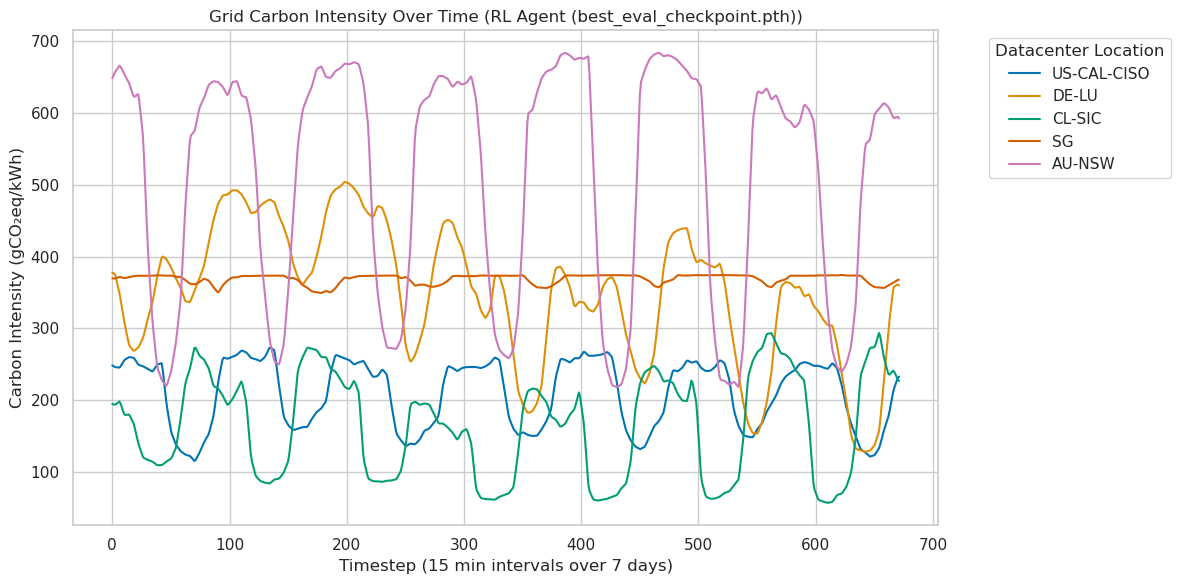

In [32]:
# Example Plot 1: Carbon Intensity at each DC
plt.figure()
sns.lineplot(data=df_detailed_steps, x="timestep", y="carbon_intensity_gco2_per_kwh", hue="plot_label", palette="colorblind")
plt.title(f"Grid Carbon Intensity Over Time ({agent_name_to_log})")
plt.xlabel(f"Timestep (15 min intervals over {EVALUATION_DURATION_DAYS} days)")
plt.ylabel("Carbon Intensity (gCO₂eq/kWh)")
plt.legend(title="Datacenter Location", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

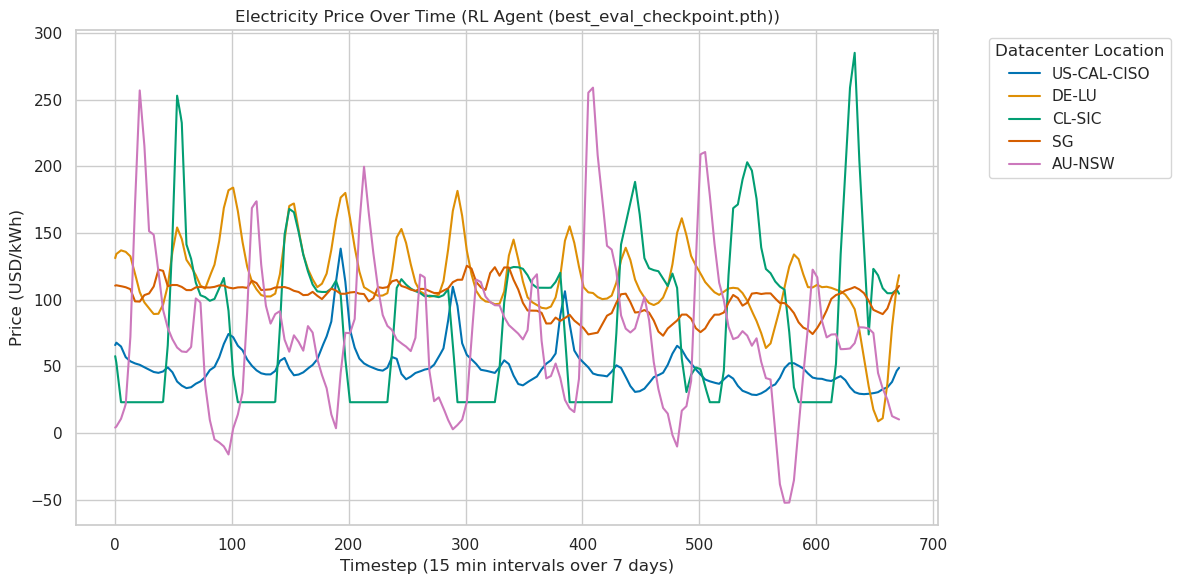

In [33]:
# Example Plot 2: Electricity Price at each DC
plt.figure()
sns.lineplot(data=df_detailed_steps, x="timestep", y="price_usd_per_kwh", hue="plot_label", palette="colorblind")
plt.title(f"Electricity Price Over Time ({agent_name_to_log})")
plt.xlabel(f"Timestep (15 min intervals over {EVALUATION_DURATION_DAYS} days)")
plt.ylabel("Price (USD/kWh)")
plt.legend(title="Datacenter Location", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

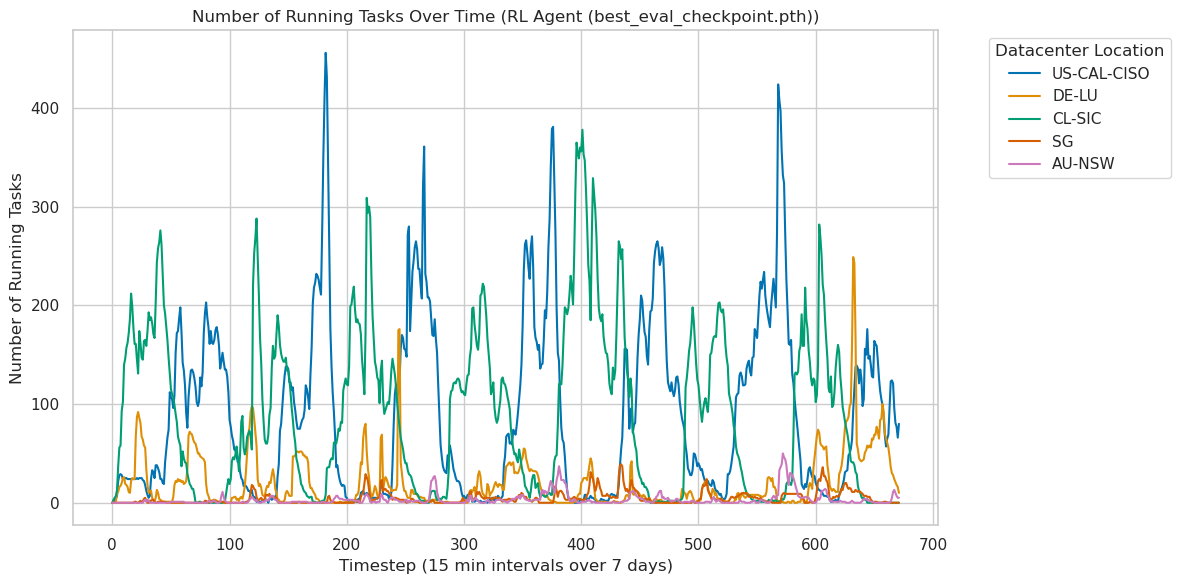

In [34]:
# Example Plot 3: Number of Running Tasks at each DC
plt.figure()
sns.lineplot(data=df_detailed_steps, x="timestep", y="running_tasks_count", hue="plot_label", palette="colorblind")
plt.title(f"Number of Running Tasks Over Time ({agent_name_to_log})")
plt.xlabel(f"Timestep (15 min intervals over {EVALUATION_DURATION_DAYS} days)")
plt.ylabel("Number of Running Tasks")
plt.legend(title="Datacenter Location", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

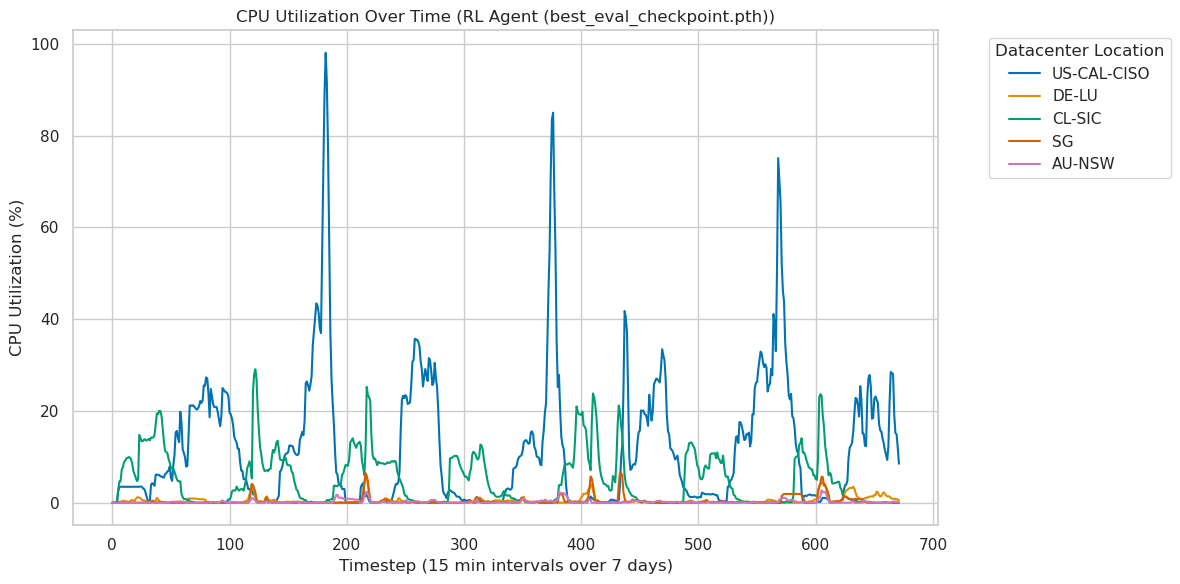

In [35]:
# Example Plot 4: CPU Utilization at each DC
plt.figure()
sns.lineplot(data=df_detailed_steps, x="timestep", y="cpu_util_percent", hue="plot_label", palette="colorblind")
plt.title(f"CPU Utilization Over Time ({agent_name_to_log})")
plt.xlabel(f"Timestep (15 min intervals over {EVALUATION_DURATION_DAYS} days)")
plt.ylabel("CPU Utilization (%)")
plt.legend(title="Datacenter Location", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

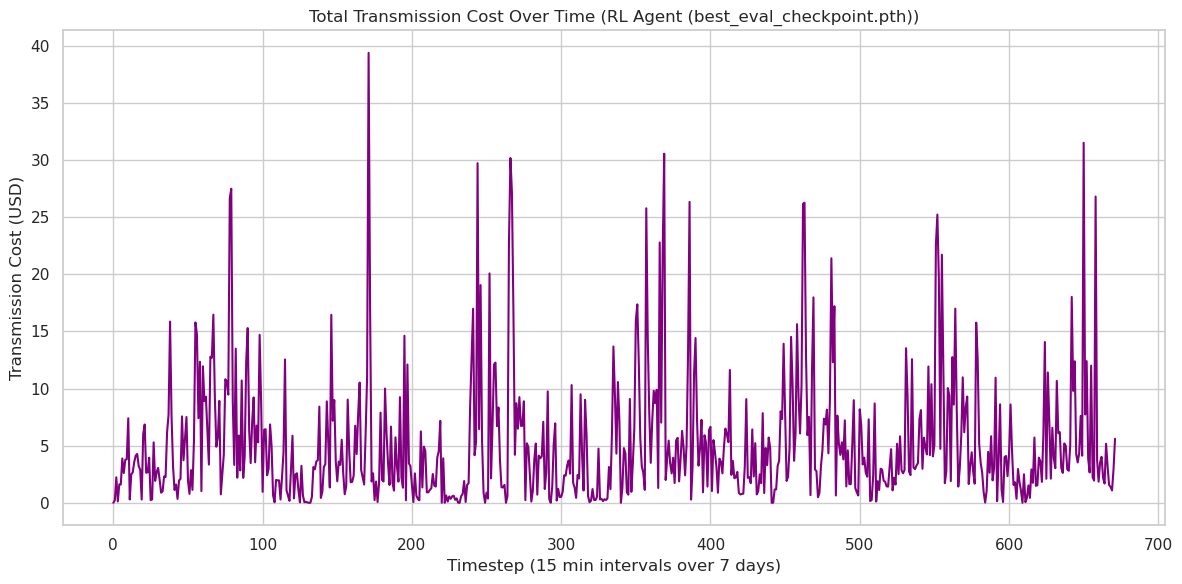

In [36]:
# Example Plot 5: Global Transmission Cost Over Time
plt.figure()
sns.lineplot(data=df_global_steps, x="timestep", y="total_transmission_cost_usd", color="purple")
plt.title(f"Total Transmission Cost Over Time ({agent_name_to_log})")
plt.xlabel(f"Timestep (15 min intervals over {EVALUATION_DURATION_DAYS} days)")
plt.ylabel("Transmission Cost (USD)")
plt.tight_layout()
plt.show()

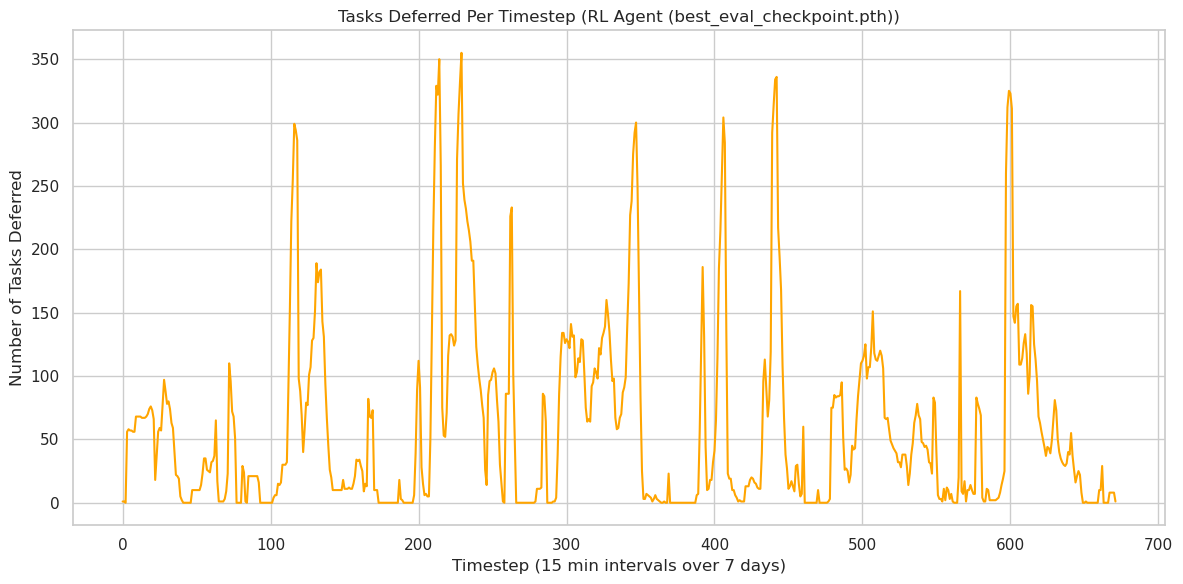

In [37]:
# Example Plot 6: Tasks Deferred Per Step (Global)
if CONTROLLER_TYPE == "RL" and not env_setup_disable_defer: # Only relevant if RL agent could defer
    plt.figure()
    sns.lineplot(data=df_global_steps, x="timestep", y="tasks_deferred_this_step", color="orange")
    plt.title(f"Tasks Deferred Per Timestep ({agent_name_to_log})")
    plt.xlabel(f"Timestep (15 min intervals over {EVALUATION_DURATION_DAYS} days)")
    plt.ylabel("Number of Tasks Deferred")
    plt.tight_layout()
    plt.show()

In [25]:
logger.info("Time-series plotting complete.")

[INFO] Time-series plotting complete.
